In [13]:
import os
import time

from datasets import load_dataset
from sklearn.metrics import precision_recall_fscore_support
import google.generativeai as ggai
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Load the Multi-EURLEX dataset
dataset = load_dataset('multi_eurlex', 'all_languages', split='test')

# Define label options (21 categories)
label_options = [
    "POLITICS", "INTERNATIONAL RELATIONS", "EUROPEAN UNION", "LAW", "ECONOMICS",
    "TRADE", "FINANCE", "SOCIAL QUESTIONS", "EDUCATION AND COMMUNICATIONS", "SCIENCE",
    "BUSINESS AND COMPETITION", "EMPLOYMENT AND WORKING CONDITIONS", "TRANSPORT",
    "ENVIRONMENT", "AGRICULTURE, FORESTRY AND FISHERIES", "AGRI-FOODSTUFFS",
    "PRODUCTION, TECHNOLOGY AND RESEARCH", "ENERGY", "INDUSTRY", "GEOGRAPHY",
    "INTERNATIONAL ORGANISATIONS"
]

# Preprocess the dataset and map true labels to category numbers
def preprocess_dataset(dataset, label_options):
    preprocessed_data = []
    for item in dataset:
        text = item['text']['en']  # Extract English text
        labels = item['labels']    # True label numbers
        preprocessed_data.append({"text": text, "labels": labels})
    # return preprocessed_data
    return preprocessed_data[:1000]

In [8]:
ggai.configure(api_key=os.getenv('GOOGLE_API_KEY'))
model = ggai.GenerativeModel('gemini-1.5-flash')

def classify_text_with_gemini(text, label_options):
    prompt = f"ONLY GIVE THE CATEGORIES IN YOUR ANSWER.Classify the following text into one or more of these categories: {', '.join(label_options)}. Text: {text}."

    # Generate the text using the model
    response = model.generate_content(prompt)

    if not response:
        print("Error: No response from the API.")
        return ""

    return response.text

In [9]:
# Extract relevant labels from Gemini's output
def extract_labels_from_generated_text(generated_text, label_options):
    relevant_labels = []
    for label in label_options:
        if label.lower() in generated_text.lower():
            relevant_labels.append(label)
    return relevant_labels

# Map label names back to indices
def map_labels_to_indices(label_names, label_options):
    label_indices = [label_options.index(label) for label in label_names if label in label_options]
    return label_indices

# Evaluate the Gemini model on the dataset
def evaluate_gemini_on_dataset(dataset, label_options):
    all_true_labels = []
    all_predicted_labels = []
    count = 0  # Track the number of requests

    for entry in dataset:
        text = entry['text']
        true_labels = entry['labels']

        try:
            # Rate limiting: Ensure no more than 15 requests per minute
            if count >= 15:
                print("Reached request limit (15 per minute). Sleeping for 60 seconds...")
                time.sleep(60)  # Sleep for 60 seconds to comply with rate limits
                count = 0  # Reset the request count after sleeping

            # Get Gemini's generated labels
            generated_text = classify_text_with_gemini(text, label_options)
            predicted_label_names = extract_labels_from_generated_text(generated_text, label_options)
            predicted_labels = map_labels_to_indices(predicted_label_names, label_options)

            # Store true and predicted labels for comparison
            all_true_labels.append(true_labels)
            all_predicted_labels.append(predicted_labels)

            # Update request count
            count += 1

        except Exception as e:
            # Handle any request-related exceptions, like rate-limiting or network errors
            print(f"Error occurred: {e}. Retrying after 60 seconds...")
            time.sleep(60)  # Sleep for 60 seconds before retrying
            count = 0  # Reset the request count

    return all_true_labels, all_predicted_labels


In [ ]:
# Preprocess the dataset
preprocessed_data = preprocess_dataset(dataset, label_options)

# Run the evaluation on the entire preprocessed dataset using Gemini
true_labels, predicted_labels = evaluate_gemini_on_dataset(preprocessed_data, label_options)

1000
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reached request limit (15 per minute). Sleeping for 60 seconds...
Reach

In [10]:
# Convert true and predicted labels to binary format using MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=list(range(len(label_options))))

# Binarize the true and predicted labels
binary_true = mlb.fit_transform(true_labels)
binary_pred = mlb.transform(predicted_labels)

# Get indices of labels with non-zero true or predicted samples
relevant_labels = np.where((binary_true.sum(axis=0) + binary_pred.sum(axis=0)) > 0)[0]

# Filter binary_true and binary_pred to only include relevant labels
filtered_binary_true = binary_true[:, relevant_labels]
filtered_binary_pred = binary_pred[:, relevant_labels]

# Calculate precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(
    filtered_binary_true, filtered_binary_pred, average='macro', zero_division=0
)

# Print the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.13978913572526372
Recall: 0.23746341402276966
F1 Score: 0.139990566339859


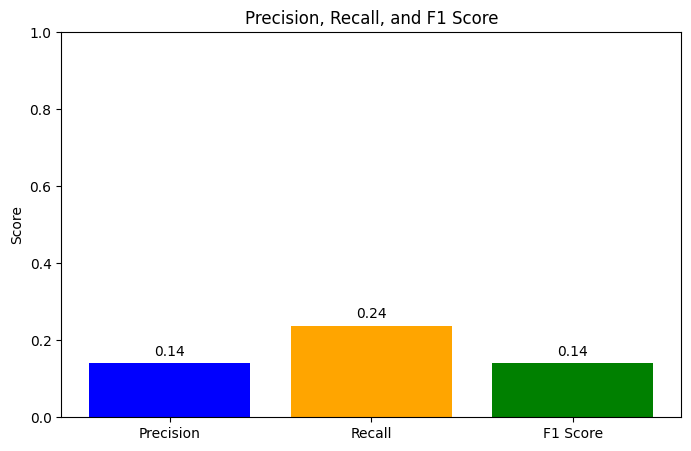

In [14]:
# Create a list for labels and scores
labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color=['blue', 'orange', 'green'])

# Add titles and labels
plt.title('Precision, Recall, and F1 Score')
plt.ylim(0, 1)  # F1 scores range from 0 to 1
plt.ylabel('Score')

# Annotate bars with their values
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center')

# Show the plot
plt.show()